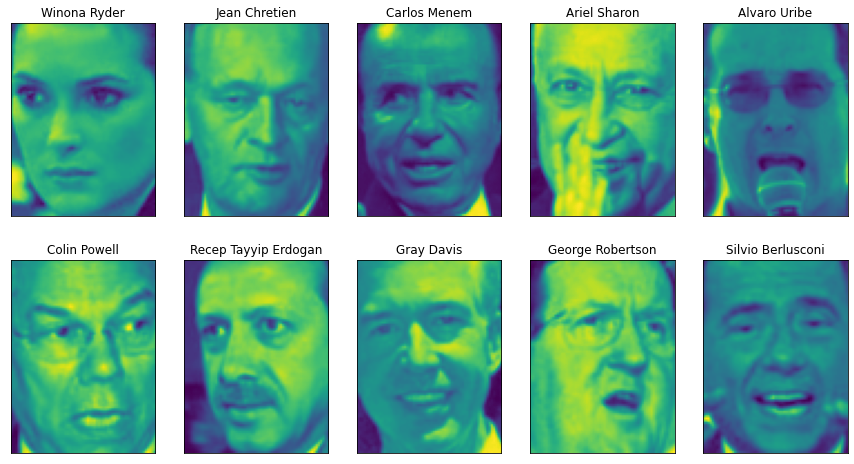

people.images.shape : (3023, 87, 65)
클래스 개수 : 62
Alejandro Toledo                 39
Alvaro Uribe                     35
Amelie Mauresmo                  21

Andre Agassi                     36
Angelina Jolie                   20
Ariel Sharon                     77

Arnold Schwarzenegger            42
Atal Bihari Vajpayee             24
Bill Clinton                     29

Carlos Menem                     21
Colin Powell                    236
David Beckham                    31

Donald Rumsfeld                 121
George Robertson                 22
George W Bush                   530

Gerhard Schroeder               109
Gloria Macapagal Arroyo          44
Gray Davis                       26

Guillermo Coria                  30
Hamid Karzai                     22
Hans Blix                        39

Hugo Chavez                      71
Igor Ivanov                      20
Jack Straw                       28

Jacques Chirac                   52
Jean Chretien                    55
Jennife

In [1]:

# coding: utf-8

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people  # fetch lfw_people library
import numpy as np



people = fetch_lfw_people(min_faces_per_person=20, resize=0.7) # 추출된 사진의 서로 다른 얼굴의 수, 사진 비율

image_shape = people.images[0].shape# people객체 image의 첫번째 원소의 모양




fig, axes =plt.subplots(2,5,figsize=(15,8),subplot_kw={'xticks':(),'yticks':()})



for target, image, ax in zip(people.target,people.images, axes.ravel()):# people.target, people.images, axes.ravel()에서 하나씩 원소 할당
    #그림 출력
    ax.imshow(image) 

    ax.set_title(people.target_names[target])

plt.show()

print("people.images.shape : {}".format(people.images.shape))

print("클래스 개수 : {}".format(len(people.target_names)))

# 각 타깃이 나타난 횟수 

counts = np.bincount(people.target)




# 타깃별 이름과 횟수 출력

for i,(count,name) in enumerate(zip(counts,people.target_names)):

    print("{0:30} {1:4}".format(name,count))

    if (i+1) %3 ==0 :

        print()
        
# 가장 작은 샘플 개수 20

In [2]:
#데이터셋이 편중되어 일부 사람으로 편향된 것을 확인할 수 있다.
#하지만 모든 데이터셋은 편향성이 있으니 
#이를 위해 사람마다 20개의 이미지만 선택하겠다.
mask = np.zeros(people.target.shape, dtype=np.bool_)



for target in np.unique(people.target):

    mask[np.where(people.target==target)[0][:20]]=1



x_people = people.data[mask]

y_people = people.target[mask]



# 0~255 사이의 흑백 이미지를 픽셀 값을 0~1 스케일로 조정

# MinMaxScaler 적용과 비슷

x_people = x_people/255.


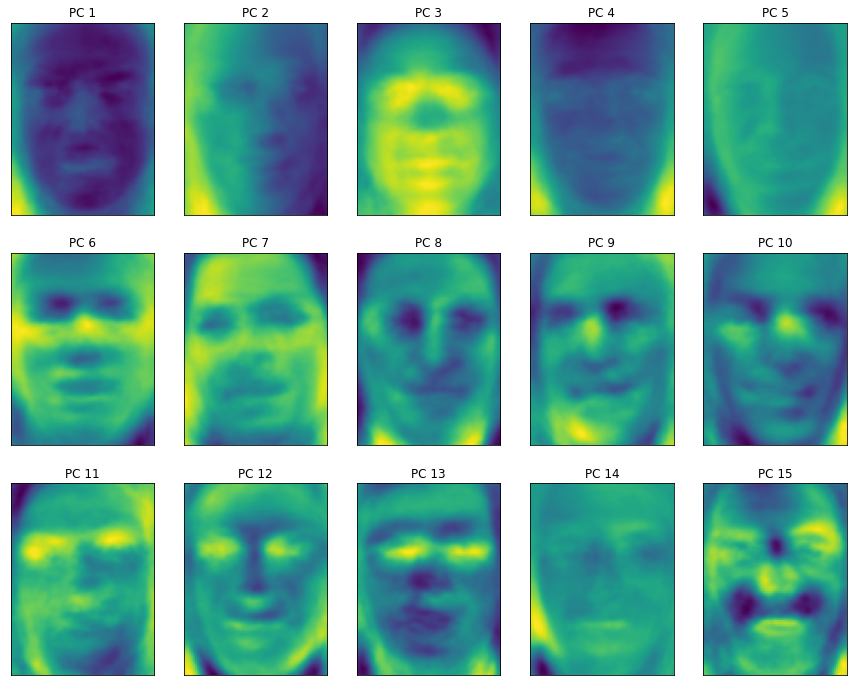

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# 테스트/훈련세트 나누기
x_train, x_test, y_train, y_test = train_test_split(x_people,y_people,stratify=y_people, random_state=0)
#PCA 모델 생성 및 적용
pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_train)# 주성분 개수, whitening option, 랜덤상태

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)


fig, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("PC {}".format(i+1))

In [4]:
#KNN 모델을 생성하여 학습시켜 결과를 설명해주세요
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_pca, y_train)
print("정확도: {:.2f}".format(knn.score(x_test_pca, y_test)))


정확도: 0.24


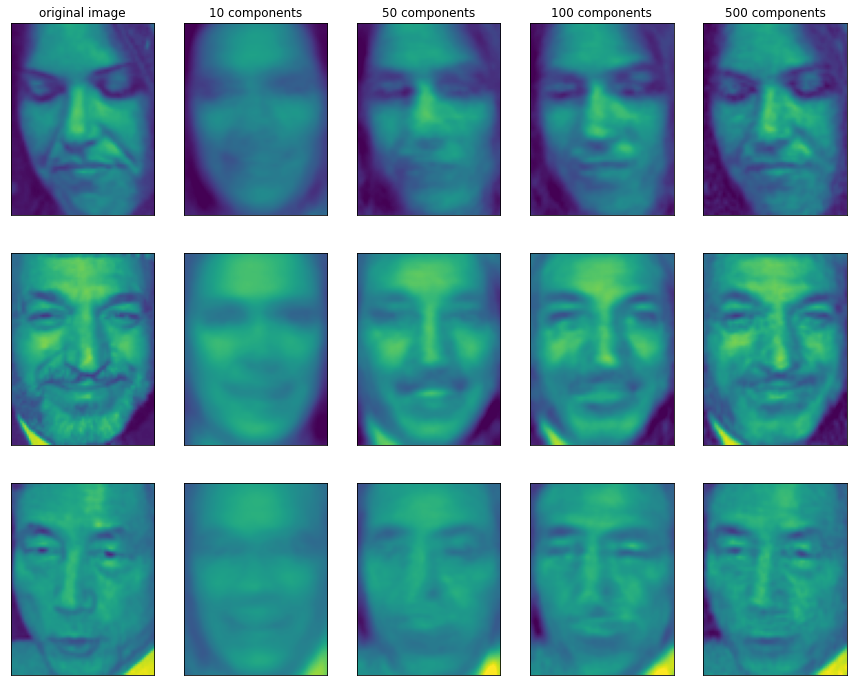

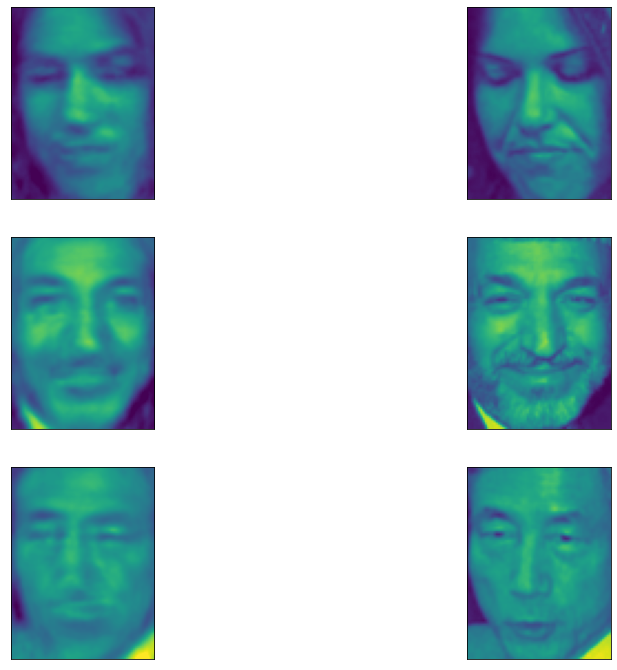

In [5]:
#주성분의 개수의 차이를 두어 얼굴 이미지 재구성
import mglearn
mglearn.plots.plot_pca_faces(x_train, x_test, image_shape)#해당 함수는 주성분의 개수의 차이에 따라 얼굴이미지를 재구성하였을 시를 보기 편하게 만들어주는 함수이다.

#아래 과정은 위의 pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_train)에서 주성분의 개수를 다르게 하여 출력한 것이다.
component_images=[]
x_test_component=pca.inverse_transform(x_test_pca)
component_images.append(x_test_component)

fig, axes = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'xticks':(), 'yticks':()})


for i, ax in enumerate(axes):
    # plot original image
    ax[1].imshow(x_test[i].reshape(image_shape), vmin=0, vmax=1)
    # plot the four back-transformed images
    for a, x_test_back in zip(ax[0:], component_images):
        a.imshow(x_test_back[i].reshape(image_shape), vmin=0, vmax=1)
    
plt.show()

In [25]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split


people = fetch_lfw_people(min_faces_per_person=100, resize=0.7)# 추출된 사진의 서로 다른 얼굴의 수, 사진 비율
#데이터셋이 편중되어 일부 사람으로 편향된 것을 확인할 수 있다.
#하지만 모든 데이터셋은 편향성이 있으니 
#이를 위해 사람마다 20개의 이미지만 선택하겠다.
mask = np.zeros(people.target.shape, dtype=np.bool_)
for target in np.unique(people.target):

    mask[np.where(people.target==target)[0][:20]]=1

x_people = people.data[mask]
y_people = people.target[mask]
x_people = np.reshape(x_people, (x_people.shape[0], people.images.shape[1], people.images.shape[2]))
x_people.shape

face_images = preprocess_input(np.array(x_people))
face_labels = to_categorical(y_people)

x_train, x_test, y_train, y_test = train_test_split(face_images,face_labels,stratify=face_labels, random_state=0)

#CNN 모델 학습
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(87,65,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train, epochs=20, batch_size=5, verbose=1, validation_split=0.2)


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 85, 63, 32)        320       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 42, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 40, 29, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 20, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 18, 12, 64)        36928     
                                                                 
 flatten_18 (Flatten)        (None, 13824)           